# Exploration of Yelp pretrained GPT model
Note: GPT uses ~WordPiece tokenization, whereas our data has text that is partly preprocessed. For example "I've" is written as "I 've", which is not consistent with GPT tokenization.

In [250]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
from tqdm.auto import tqdm, trange

plt.style.use('fivethirtyeight')

EOS = '<|endoftext|>'

In [47]:
model_path = '../deep-latent-sequence-model/yelp_gpt/checkpoint-600/'
assert os.path.exists(model_path)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt = GPT2LMHeadModel.from_pretrained(model_path).eval()

In [48]:
tokenizer.tokenize('<|endoftext|>')

['<|endoftext|>']

In [49]:
sentence = "You can do whatever you want"
tokenizer.tokenize(sentence)

['You', 'Ġcan', 'Ġdo', 'Ġwhatever', 'Ġyou', 'Ġwant']

In [313]:
tokenizer.tokenize("I've been quite tired"), tokenizer.tokenize("I 've been quite tired")

(['I', "'ve", 'Ġbeen', 'Ġquite', 'Ġtired'],
 ['I', "Ġ'", 've', 'Ġbeen', 'Ġquite', 'Ġtired'])

In [50]:
encoding = tokenizer.encode(sentence)
encoding

[1639, 460, 466, 4232, 345, 765]

In [51]:
tokenizer.decode(encoding)

'You can do whatever you want'

In [52]:
output = gpt(torch.tensor(encoding))
len(output)

2

In [53]:
logits = output[0]  # logits
logits.shape

torch.Size([6, 50257])

In [54]:
output[1].__len__()  # hidden states

12

In [61]:
preds = logits.argmax(1)
preds

tensor([423, 635, 326, 345, 765, 351], grad_fn=<NotImplemented>)

In [71]:
encoding

[1639, 460, 466, 4232, 345, 765]

In [77]:
words = tokenizer.tokenize(sentence)
for i in range(len(words)):
    beginning = tokenizer.decode(encoding[:i+1])
    predicted_continuation = tokenizer.decode(preds[i].item())
    print(beginning, '-->', predicted_continuation)

You -->  have
You can -->  also
You can do -->  that
You can do whatever -->  you
You can do whatever you -->  want
You can do whatever you want -->  with


## Generation of sentences by GPT (deterministic)

In [145]:
sentence = "I"
while not '<|endoftext|>' in sentence:
    tokens = tokenizer(sentence)['input_ids']
    print(sentence, tokens)
    logits = gpt(torch.tensor(tokens))[0][-1]  # -1 because we want to predict next word
    prediction = logits.argmax().item()
    next_word = tokenizer.decode(prediction)
    sentence += next_word
sentence

I [40]
I have [40, 423]
I have never [40, 423, 1239]
I have never had [40, 423, 1239, 550]
I have never had a [40, 423, 1239, 550, 257]
I have never had a problem [40, 423, 1239, 550, 257, 1917]
I have never had a problem with [40, 423, 1239, 550, 257, 1917, 351]
I have never had a problem with this [40, 423, 1239, 550, 257, 1917, 351, 428]
I have never had a problem with this place [40, 423, 1239, 550, 257, 1917, 351, 428, 1295]
I have never had a problem with this place. [40, 423, 1239, 550, 257, 1917, 351, 428, 1295, 13]
I have never had a problem with this place.  [40, 423, 1239, 550, 257, 1917, 351, 428, 1295, 13, 220]


'I have never had a problem with this place. <|endoftext|>'

## Generation of sentences by GPT (sampling)

In [232]:
sentence = "I"
tokens = tokenizer(sentence)['input_ids']
logits = gpt(torch.tensor(tokens))[0][-1].detach()  # -1 because we want to predict next word
weights = logits.softmax(0).detach().numpy()

In [233]:
words = [tokenizer.decode(i) for i in range(len(tokenizer))]

In [234]:
words_probas = sorted(list(zip(words, weights)), key=lambda t: t[1], reverse=True)

In [235]:
words_probas[:10]

[(' have', 0.06487966),
 (' was', 0.042957008),
 (' is', 0.016502878),
 (' will', 0.015861038),
 (' really', 0.015011546),
 (' had', 0.014971742),
 (' do', 0.014660895),
 (' are', 0.014455805),
 ('\n', 0.01430184),
 (' would', 0.01295054)]

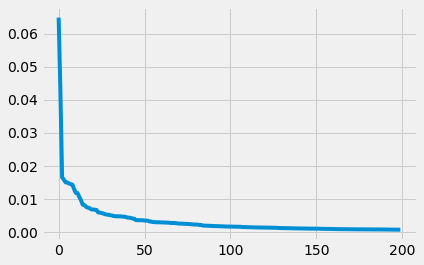

In [236]:
plt.plot([p for _, p in words_probas[:200]]);

In [240]:
prediction = random.choices(list(range(len(logits))), weights=logits.softmax(0))[0]
tokenizer.decode(prediction)

' will'

In [244]:
sentence = "I"
while not EOS in sentence and len(sentence) < 1_000:
    tokens = tokenizer(sentence)['input_ids']
    logits = gpt(torch.tensor(tokens))[0][-1].detach()
    weights = logits.softmax(0).detach().numpy()
    prediction = random.choices(list(range(len(logits))), weights=logits.softmax(0))[0]
    sentence += tokenizer.decode(prediction)
sentence

'I and my dog love this shop. <|endoftext|>'

In [276]:
def sample_sentence_from(model, tokenizer, sentence, stop_after_dot=True):
    while not EOS in sentence and len(sentence) < 300:
        if stop_after_dot and '.' in sentence:
            break
        tokens = tokenizer(sentence)['input_ids']
        logits = model(torch.tensor(tokens))[0][-1].detach()
        weights = logits.softmax(0).detach().numpy()
        prediction = random.choices(list(range(len(logits))), weights=logits.softmax(0))[0]
        sentence += tokenizer.decode(prediction)
    return sentence

In [278]:
random.seed(1)
for _ in trange(30):
    print(sample_sentence_from(gpt, tokenizer, "The", stop_after_dot=False))

The other definition was that they disassembled some of the nail pieces.


in 1993 i was a regular nail technician and she is on my family. <|endoftext|>
The looking for a theater through i`ve heard of this experiences. _num_ stars they had split fairly quickly. <|endoftext|>
The stuck asic oil used for my quote 's. <|endoftext|>
The soprano dinners are always very clean! The fish tacos are quick & delicious. <|endoftext|>
The hottest szechuan flavor ever! <|endoftext|>
The done of machinist. <|endoftext|>
The i 'm complete. <|endoftext|>
The how 's away star? <|endoftext|>
The grand of a beehive is pretty popular in the neighborhood. <|endoftext|>
The video was taken the day before the game started. <|endoftext|>
The dozen ancillary functions on our plate were just icing on the cake. <|endoftext|>
The big difference in this wo wo n't be attending another church again., the rental contractor. <|endoftext|>
Theactus brothers were well known in one way or another. <|endoftext|>
The best 

In [279]:
gpt_original = GPT2LMHeadModel.from_pretrained('gpt2').eval()

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentences are quite good. Note however, that GPT2 sometimes generates sentences that are long and contain new line characters. This is because of the influence of how is was trained. For example, it generated: 
```
The other definition was that they disassembled some of the nail pieces.


in 1993 i was a regular nail technician and she is on my family. <|endoftext|>
```
This piece contains two new line characters and two sentences. There are other similar examples. random.seed(1)

## Orignal GPT2 comparison
To see that our pretraining achieved something, we compare sentence generation with original GPT2, to see that the content is different. It is indeed the case, our generated texts contain a lot of opinions about food and restaurants.

In [282]:
for _ in range(10):
    print(sample_sentence_from(gpt_original, tokenizer, "The", stop_after_dot=True))

The 3 points are going the way of 3 seed LaHaye because you both tripped my boy," Tyareth July 31.
The Argentinian deli manager Pedro Montesario said the new places would not be opened.
The offer follows much of the increased interest in DIY students, capitalizing on an emerging interest in cognitive imaging.
The Office of Civil Rights referred residents to the PreventED Persons and Mumia Abu Hamza Civil Justice Director.
The amassed stockholders then discovered that their control of life did not rest with those who were simply sitting in the New York Stock Exchange, those named Cecil Benjamin Bamber.
The Holodomorces of the Pale Institute (Mira Turchinson Oslo) contains twelve unique animals that pose the greatest challenge to dinosaurs, and while the secret to their longevity begins to be understood, it is as a nation's survival skills that will determine whether they will be extinct or get lost
The center's most popular weapons of choice are metal pipes that score lower on Canberra'

## Adding special tokens to Tokenizer

In [306]:
sentence = "<POS> I love it <|endoftext|>"
encoding = tokenizer(sentence)["input_ids"]
[tokenizer.decode(t) for t in encoding]

['<', 'POS', '>', ' I', ' love', ' it', ' ', '<|endoftext|>']

In [308]:
tokenizer.add_tokens(["<|positive|>", "<|negative|>"])

2

In [310]:
sentence = "<|positive|> I love it <|endoftext|>"
encoding = tokenizer(sentence)["input_ids"]
[tokenizer.decode(t) for t in encoding]

['<|positive|>', 'I', ' love', ' it', ' ', '<|endoftext|>']

In [311]:
sentence = "<|negative|> I love it <|endoftext|>"
encoding = tokenizer(sentence)["input_ids"]
[tokenizer.decode(t) for t in encoding]

['<|negative|>', 'I', ' love', ' it', ' ', '<|endoftext|>']